In [8]:
from keras.models import load_model
import cv2
import keras2onnx
import ffmpeg
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

ModuleNotFoundError: No module named 'keras2onnx'

# Rotation management
In some situations opencv reads a video but cannot understand the rotation codecs, and rotates the video and the extracted frames, this method is used to read the codecs and rotate the video in the right way, because dlib does not recognize the rotated faces

In [2]:
def check_rotation(path_video_file):
     # returns the meta-data of the dictionary-style videos
    meta_dict = ffmpeg.probe(path_video_file)

    # rotate parameter search
    rotateCode = None
    try:
        if int(meta_dict['streams'][0]['tags']['rotate']) == 90: #see if in the video meta-data the roate parameter is 90
            rotateCode = cv2.ROTATE_90_CLOCKWISE
        elif int(meta_dict['streams'][0]['tags']['rotate']) == 180: #see if in the video meta data the roate parameter is 180
            rotateCode = cv2.ROTATE_180
        elif int(meta_dict['streams'][0]['tags']['rotate']) == 270: #see if in the video meta data the roate parameter is 270
            rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE
    #exception if it doesn't find the rotate parameter
    except:
        print('find no rotate attribute')

    return rotateCode

In [3]:
def correct_rotation(frame, rotateCode):  
    return cv2.rotate(frame, rotateCode) 

# Execution Of Model

In [4]:
#the network is performed on the frame
def model_execution(img,modelA):
    output = []
    proba = modelA.predict(img.reshape(1,150,150,3))
    i = 0
    for i in range(2):
        if(i==0):
            body = proba[0][i]
        elif(i==1):
            face= proba[0][i]
    return face,body

# Sort Algorithm

In [5]:
#array sorting function
def binary_search_inverse(arr, val, start, end): 
    if start == end: 
        if arr[start] < val: 
            return start
        else: 
            return start+1
  
    if start > end: 
        return start
  
    mid = (start+end)/2
    mid = int(mid)
    if arr[mid] < val: 
        return binary_search_inverse(arr, val, start, mid-1)
    elif arr[mid] > val: 
        return binary_search_inverse(arr, val, mid+1, end) 
    else: 
        return mid

# Best Frame Calculation
we use this function to calculate the best frame n frame, in descendent order, in which the best frame became the first element of of array, the second element of array is the frame that has a score less than the first and so on.

In [6]:
def valutatore(arr_accuracy,arr_img,arr_or_img,or_img, val, img, n_frame_best):
    n = len(arr_accuracy)
    pos = binary_search_inverse(arr_accuracy, val, 0, n-1)   
    if(pos<=n_frame_best-1):
        arr_accuracy.insert(pos,val)
        arr_img.insert(pos,img)
        arr_or_img.insert(pos, or_img)
        if(len(arr_accuracy)>n_frame_best):
            arr_accuracy.pop()
            arr_img.pop()
            arr_or_img.pop()
    return arr_accuracy, arr_img

# Best Frame Result
Here we execute the model on the frame, take the best frame and print them

find no rotate attribute
extraction...
range(0, 4)
extraction ended


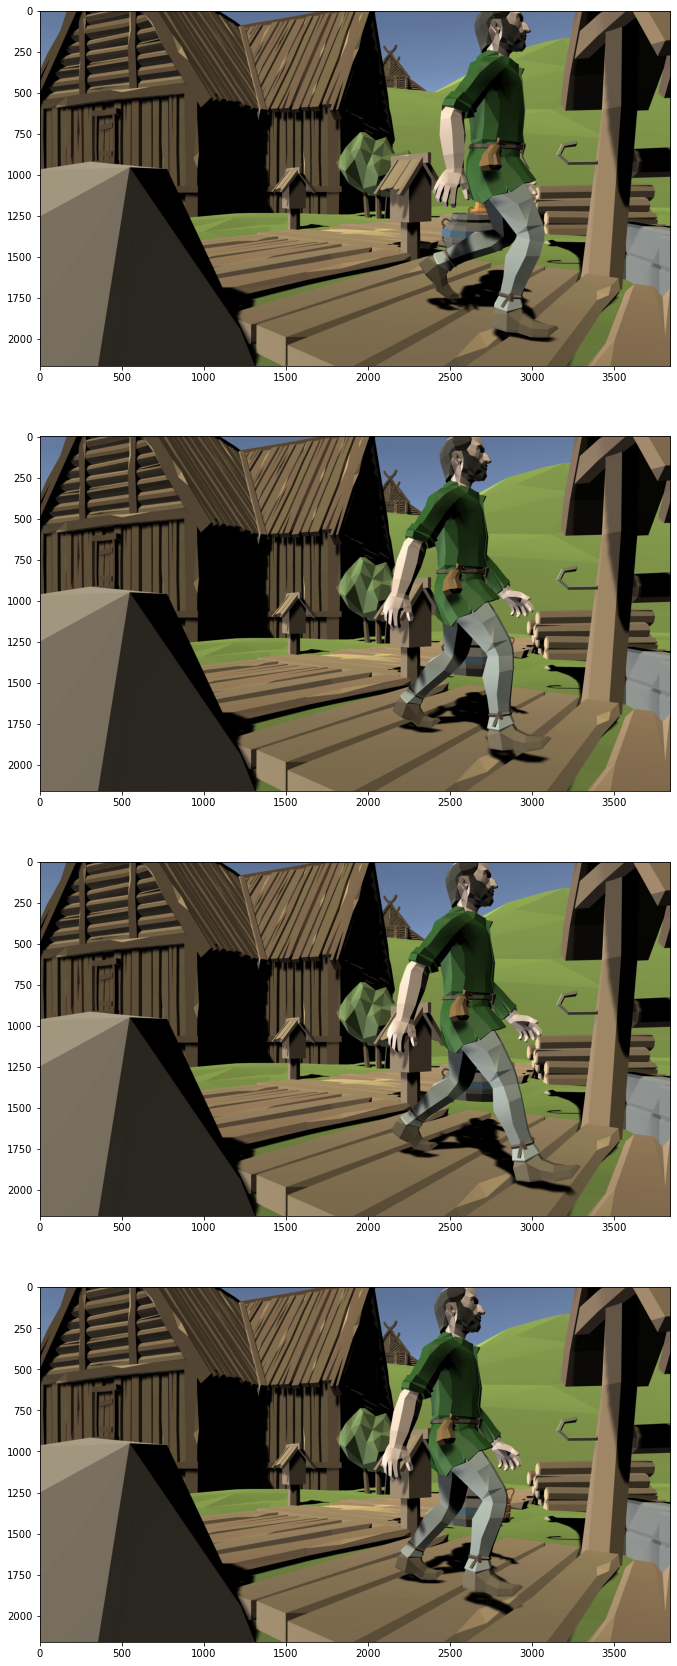

In [7]:
inputVideo = "test.mp4"
n_frame_best = 4
arr_accuracy = []
arr_img = []
arr_or_img = []
modelA = load_model('ModelloAllenato_shuffle.hdf5')
cap = cv2.VideoCapture(inputVideo)# input a video whose frames you want to extract
 # let's see if the video requires rotation
rotateCode = check_rotation(inputVideo)
 #   loop frame by frame
print("extraction...")
while True:
    grabbed, frame = cap.read()

     # if the grabbed parameter is false the video is finished
    if not grabbed:
        break

     # check if the video should be rotated
    if rotateCode is not None:
        frame = correct_rotation(frame, rotateCode)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    or_img = frame.copy()
    frame = image.img_to_array(frame)
    frame = cv2.resize(frame,(150,150))
    frame = frame/255
    face, body = model_execution(frame,modelA)
    val = face+body/2
    arr_accuracy, arr_img = valutatore(arr_accuracy,arr_img,arr_or_img,or_img , val, frame, n_frame_best)
#print and save n best frame
x=0
print(range(len(arr_img)))
columns = 1
rows = n_frame_best
fig=plt.figure(figsize=(30, 30))
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(arr_or_img[i-1])
for x in range(len(arr_img)):
    cv2.imwrite('C:\\Users\\CASALAB\\Desktop\\progetto_CASA\\Final\\N_best_frame/'+str(x)+'.jpg',cv2.cvtColor(arr_or_img[x], cv2.COLOR_BGR2RGB))
cap.release()
cv2.destroyAllWindows()
print("extraction ended")
